# TP1 - Parte B: Classificação de Atividades Humanas 
### Tópicos de Ciência dos Dados - MECD (2022/2023)

### Autores

- Duarte Meneses - 2019216949
- Patricia Costa - 2019213995


In [159]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd

## 4.5 e 4.6 da Parte A

### 4.5. ReliefF

In [160]:
from ReliefF import ReliefF

def reliefF(x, y):
    fs = ReliefF(n_features_to_keep=10)
    fs.fit_transform(x, y)

    return fs.top_features[:10]

### 4.6. Fisher Score

In [161]:
from skfeature.function.similarity_based import fisher_score

def fisherScore(x, y):
    return fisher_score.fisher_score(x, y)

## Parte B


### 1.1. Data Splitting

### 1.1.1. Train-Test (TT) e Train-Validation-Test data split

In [162]:
from sklearn.model_selection import train_test_split
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

def train_test(data, target, train_size):

    x_train, x_test, y_train, y_test = train_test_split(data, target, train_size=train_size)

    trainTest = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]}

    return trainTest

def train_validation_test(data, target, train_size, test_size):

    x_train, x_rem, y_train, y_rem = train_test_split(data, target, train_size=train_size)

    # 1 - train_size -> correponde agora ao nosso 100%(1)
    # test_size -> test_size / (1-train_size)

    test = test_size / (1-train_size)

    x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size = test)

    trainValidation = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test], "VALIDATION": [x_valid, y_valid]}
    
    return trainValidation



### 1.1.2. K-fold data split

In [163]:
from sklearn.model_selection import KFold
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

def k_fold(x, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle = True)
    kfold = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        kfold.append({"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]})
    
    return kfold

In [164]:
#Testes
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

print("--Train Test--\n")
trainTest = train_test(X, y, 0.7)
display(trainTest)

print("\n--Train Validation Test--\n")
trainValidation = train_validation_test(X, y, 0.4, 0.3)
display(trainValidation)

print("\n--K Fold--\n")
kFold = k_fold(X, y, 4)
display(kFold)

--Train Test--



{'TRAIN': [array([[1, 2],
         [3, 4]]),
  array([3, 2])],
 'TEST': [array([[1, 2],
         [3, 4]]),
  array([1, 4])]}


--Train Validation Test--



{'TRAIN': [array([[1, 2]]), array([1])],
 'TEST': [array([[3, 4],
         [3, 4]]), array([4, 2])],
 'VALIDATION': [array([[1, 2]]), array([3])]}


--K Fold--



[{'TRAIN': [array([[3, 4],
          [1, 2],
          [3, 4]]),
   array([2, 3, 4])],
  'TEST': [array([[1, 2]]), array([1])]},
 {'TRAIN': [array([[1, 2],
          [1, 2],
          [3, 4]]),
   array([1, 3, 4])],
  'TEST': [array([[3, 4]]), array([2])]},
 {'TRAIN': [array([[1, 2],
          [3, 4],
          [1, 2]]),
   array([1, 2, 3])],
  'TEST': [array([[3, 4]]), array([4])]},
 {'TRAIN': [array([[1, 2],
          [3, 4],
          [3, 4]]),
   array([1, 2, 4])],
  'TEST': [array([[1, 2]]), array([3])]}]

### 1.2. Métricas de exactidação

In [165]:
#Teste
true = [2, 0, 2, 2, 0, 1]
pred = [0, 0, 2, 2, 0, 2]

-> Explicação do parâmetro average

**'binary'**:
Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.

**'micro'**:
Calculate metrics globally by counting the total true positives, false negatives and false positives.

**'macro'**:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

**'weighted'**:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

**'samples'**:
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

,Metrics
Recall,0.666667
Precision,0.555556
F1-score,0.600000


,0,1,2
0,2,0,0
1,0,0,1
2,1,0,2


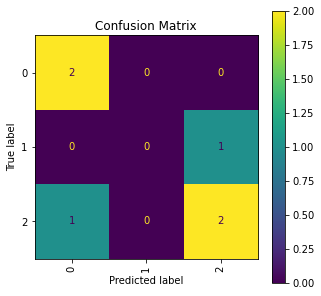

In [166]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import recall_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
from sklearn.metrics import precision_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
from sklearn.metrics import f1_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

def metrics(true, pred, printar = False):

    cm = confusion_matrix(true, pred)
    rs = recall_score(true, pred, average='weighted', zero_division=0)
    ps = precision_score(true, pred, average='weighted', zero_division=0)
    f1 = f1_score(true, pred, average='weighted', zero_division=0)

    if(printar):
        print('Confusion Matrix:\n', cm)
        print('\nRecall: ', rs)
        print('\nPrecision: ', ps)
        print('\nF1-score: ', f1)
        print('-'*50)

    return [cm, rs, ps, f1]

def mais_bonito(cm, rs, ps, f1, labels):

    metricsFrame = pd.DataFrame([rs, ps, f1], columns=['Metrics']).rename(index={0: 'Recall', 1: 'Precision', 2: 'F1-score'})
    display(metricsFrame)

    try:
        cmFrame = pd.DataFrame(cm, columns=labels, index=labels).style.set_caption("Confusion Matrix")
        display(cmFrame)

        cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
        _, ax = plt.subplots(figsize=(5,5))
        cmp.plot(ax=ax)
        ax.set_title("Confusion Matrix")
        ax.xaxis.set_ticklabels(labels, rotation=90)
        ax.yaxis.set_ticklabels(labels)
        plt.show()

    except:
        cmFrame = pd.DataFrame(cm).style.set_caption("Confusion Matrix")
        display(cmFrame)

cm, rs, ps, f1 = metrics(true, pred)
mais_bonito(cm, rs, ps, f1, [0,1,2])



### 2.1. Dataset

In [167]:
iris = datasets.load_iris()

data = iris.data
target = iris.target

display(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

### 2.1. k-Nearest Neighbours

In [168]:
from sklearn.neighbors import KNeighborsClassifier

def K_neighbors_classifier(x, y, k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x, y)

    return neigh


### 2.1.1. Train-only

,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


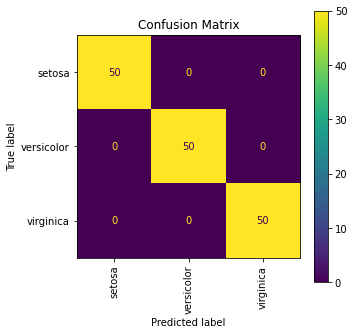

In [169]:
def TO_211(x, y, labels, k):
    neigh = K_neighbors_classifier(x, y, k)
    pred = neigh.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TO_211(data, target, iris["target_names"], 1)

### 2.1.1. TT 70-30

,Metrics
Recall,0.955556
Precision,0.955556
F1-score,0.955556


,setosa,versicolor,virginica
setosa,21,0,0
versicolor,0,12,1
virginica,0,1,10


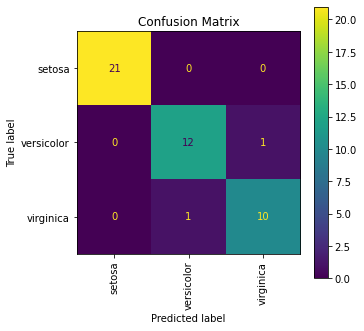

In [170]:
def TT_211(x, y, labels, k):
    trainTest = train_test(x, y, 0.7)
    neigh = K_neighbors_classifier(trainTest['TRAIN'][0], trainTest['TRAIN'][1], k)
    pred = neigh.predict(trainTest['TEST'][0])
    true = trainTest['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TT_211(data, target, iris["target_names"], 1)

### 2.1.1. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


,Metrics
Recall,0.933333
Precision,0.944444
F1-score,0.932660


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,4,1
virginica,0,0,5


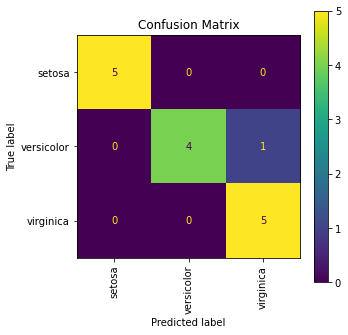

------------------- Iteração 1 -------------------


,Metrics
Recall,0.933333
Precision,0.946667
F1-score,0.933333


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,4,1
virginica,0,0,4


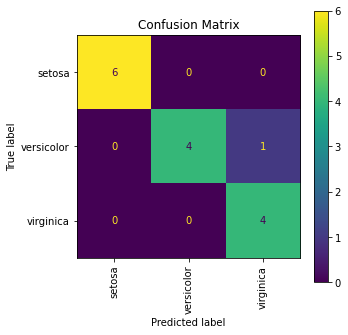

------------------- Iteração 2 -------------------


,Metrics
Recall,0.933333
Precision,0.942857
F1-score,0.931136


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,6,0
virginica,0,1,3


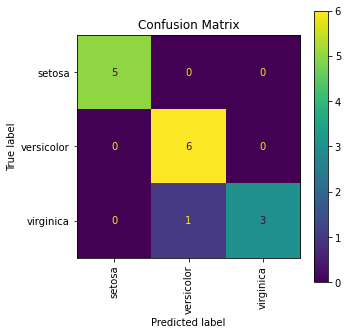

------------------- Iteração 3 -------------------


,Metrics
Recall,0.933333
Precision,0.946667
F1-score,0.934007


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,5,1
virginica,0,0,4


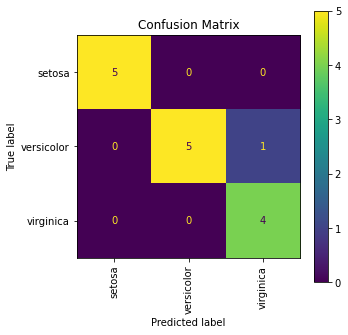

------------------- Iteração 4 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,3,0
virginica,0,0,6


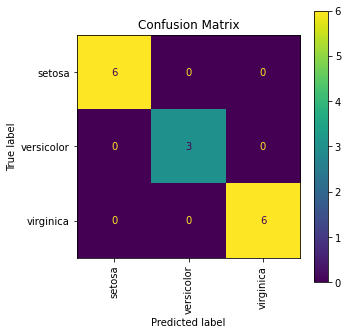

------------------- Iteração 5 -------------------


,Metrics
Recall,0.933333
Precision,0.946667
F1-score,0.934473


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,4,0
virginica,0,1,6


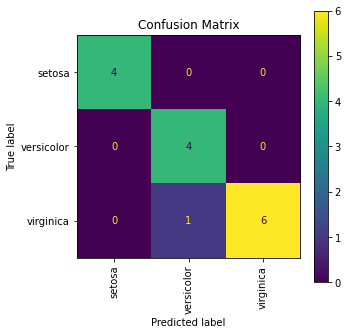

------------------- Iteração 6 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,3,0,0
versicolor,0,9,0
virginica,0,0,3


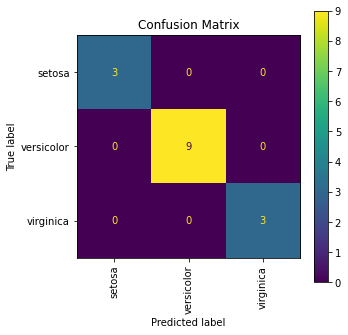

------------------- Iteração 7 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,4,0
virginica,0,0,5


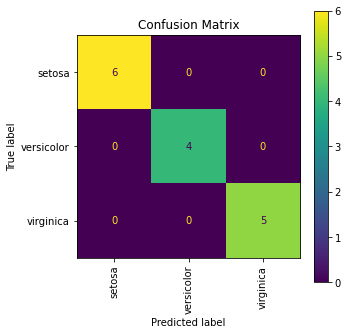

------------------- Iteração 8 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,5,0
virginica,0,0,6


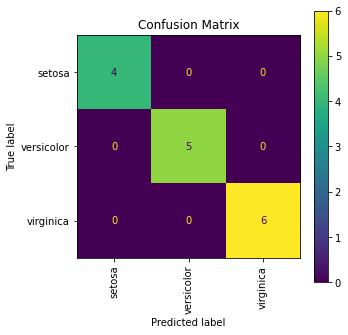

------------------- Iteração 9 -------------------


,Metrics
Recall,0.933333
Precision,0.950000
F1-score,0.935065


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,3,0
virginica,0,1,5


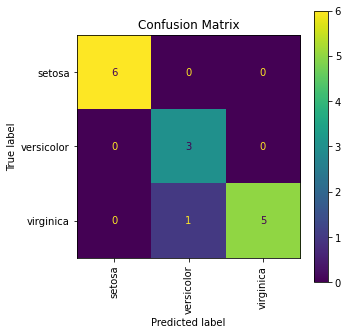

In [171]:
def CV_211(x, y, n_splits, labels, k):
    kf = k_fold(x, y, n_splits)

    count = 0
    for info in kf:
        print("------------------- Iteração " + str(count) + " -------------------")

        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]

        cm, rs, ps, f1 = metrics(true, pred)

        mais_bonito(cm, rs, ps, f1, labels)

        count += 1

CV_211(data, target, 10, iris["target_names"], 1)

### 2.1.2. k na gama {1, 3, 5, ...,15}

In [172]:
_k = np.arange(1, 16, 2)

display(_k)

array([ 1,  3,  5,  7,  9, 11, 13, 15])

### 2.1.2. Train-only

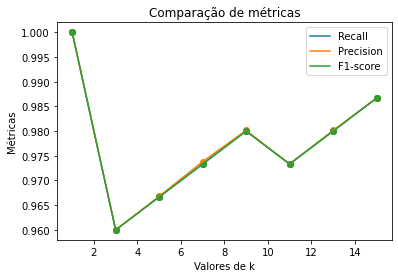

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


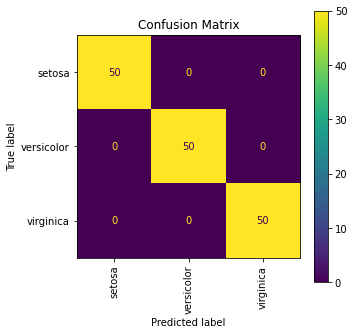

In [173]:
def TO_212(x, y, metr):
    for k in _k:
        neigh = K_neighbors_classifier(x, y, k)
        pred = neigh.predict(x)
        true = y
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)

    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def TO_gama(x, y, labels):
    metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
    
    new_metr = TO_212(x, y, metr)

    plot_metricas(new_metr)

    pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
    best_k = _k[pos_k]
    print("Best K: " + str(best_k))

    neigh = K_neighbors_classifier(x, y, best_k)
    pred = neigh.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)

    mais_bonito(cm, rs, ps, f1, labels)

TO_gama(data, target, iris["target_names"])

### 2.1.2. TVT 40-30-30

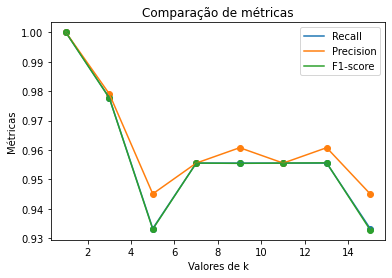

Best K: 1


,Metrics
Recall,0.933333
Precision,0.944444
F1-score,0.932016


,setosa,versicolor,virginica
setosa,17,0,0
versicolor,0,15,0
virginica,0,3,10


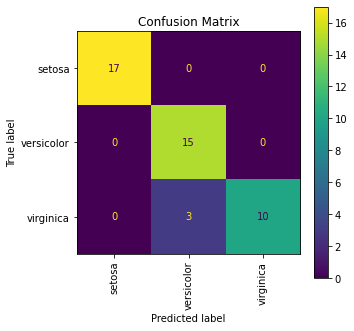

In [174]:
# TODO
# VER O MELHOR K -> FEITO
# PARA O MELHOR K, TESTAR COM O TREINO + VALIDATION JUNTOS, USANDO O TEST COMO PRED


def TVT_212(x, y, metr):
    for k in _k:
        trainValidation = train_validation_test(x, y, 0.4, 0.3)

        neigh = K_neighbors_classifier(trainValidation['TRAIN'][0], trainValidation['TRAIN'][1], k)
        pred = neigh.predict(trainValidation['VALIDATION'][0])
        true = trainValidation['VALIDATION'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)
    
    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def TVT_gama(x, y, labels, printar=True):
    metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
    
    new_metr = TVT_212(x, y, metr)

    plot_metricas(new_metr)

    pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
    best_k = _k[pos_k]
    print("Best K: " + str(best_k))

    trainValidation = train_validation_test(x, y, 0.4, 0.3)

    newTrain0 = np.concatenate((trainValidation['TRAIN'][0], trainValidation['VALIDATION'][0]), axis=0)
    newTrain1 = np.concatenate((trainValidation['TRAIN'][1], trainValidation['VALIDATION'][1]), axis=0)

    neigh = K_neighbors_classifier(newTrain0, newTrain1, best_k)
    pred = neigh.predict(trainValidation['TEST'][0])
    true = trainValidation['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    if(printar):
        mais_bonito(cm, rs, ps, f1, labels)

TVT_gama(data, target, iris["target_names"])

### 2.1.2. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


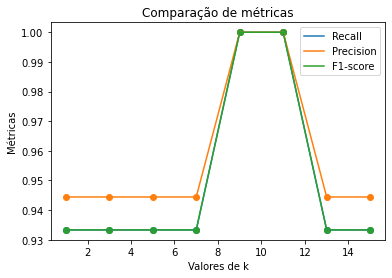

Best K: 9


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,6,0
virginica,0,0,5


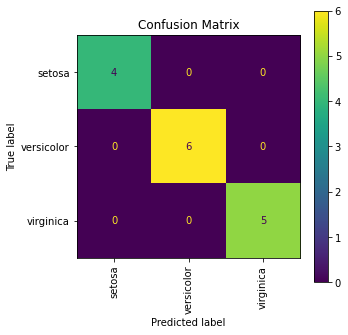

------------------- Iteração 1 -------------------


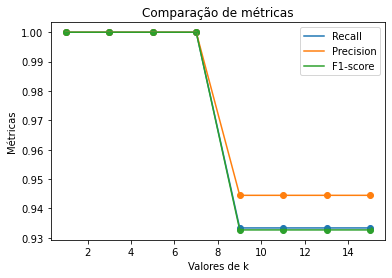

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,5,0
virginica,0,0,5


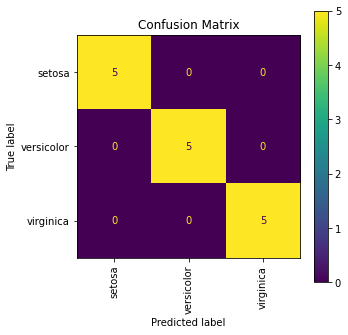

------------------- Iteração 2 -------------------


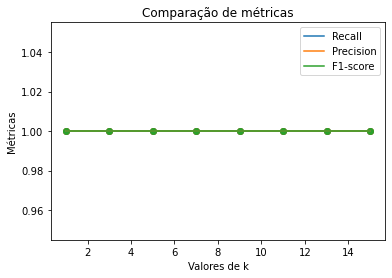

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,10,0,0
versicolor,0,2,0
virginica,0,0,3


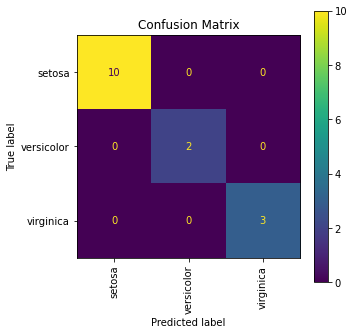

------------------- Iteração 3 -------------------


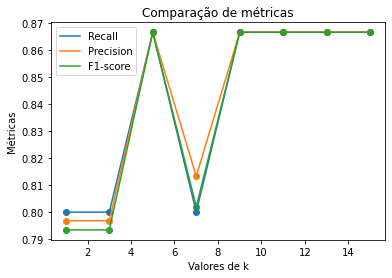

Best K: 5


,Metrics
Recall,0.866667
Precision,0.866667
F1-score,0.866667


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,5,1
virginica,0,1,3


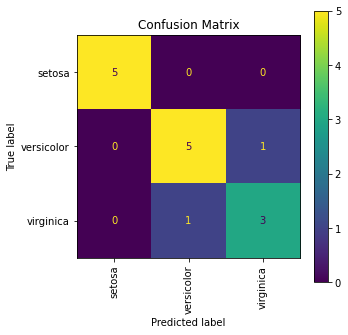

------------------- Iteração 4 -------------------


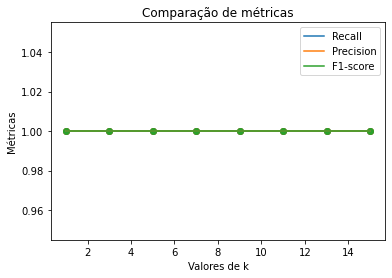

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,3,0,0
versicolor,0,5,0
virginica,0,0,7


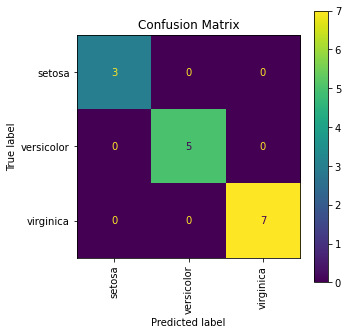

------------------- Iteração 5 -------------------


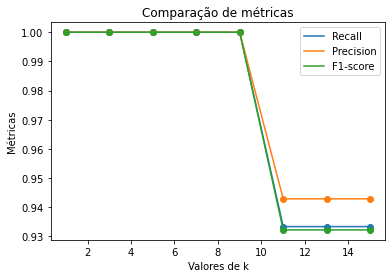

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,6,0
virginica,0,0,5


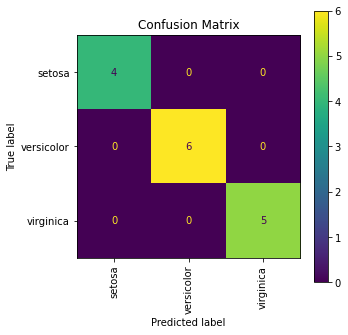

------------------- Iteração 6 -------------------


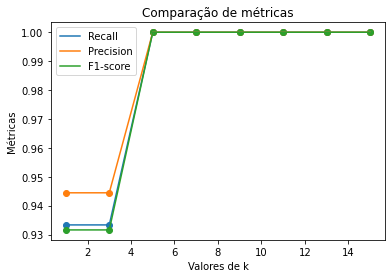

Best K: 5


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,5,0
virginica,0,0,4


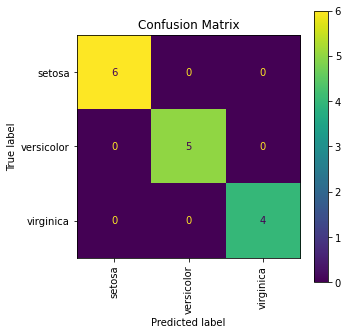

------------------- Iteração 7 -------------------


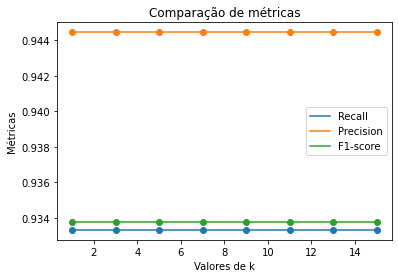

Best K: 1


,Metrics
Recall,0.933333
Precision,0.944444
F1-score,0.933800


,setosa,versicolor,virginica
setosa,3,0,0
versicolor,0,6,1
virginica,0,0,5


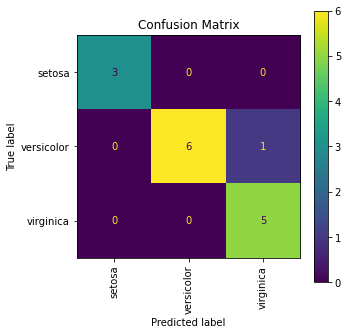

------------------- Iteração 8 -------------------


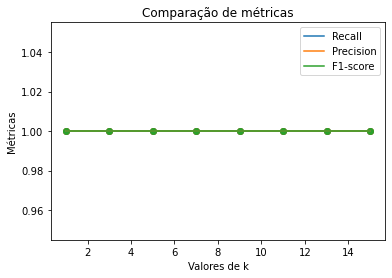

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,3,0
virginica,0,0,6


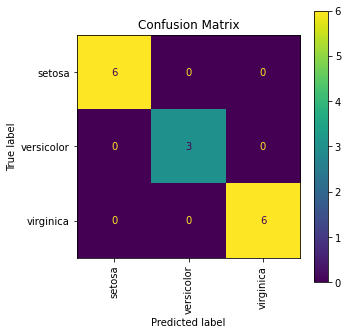

------------------- Iteração 9 -------------------


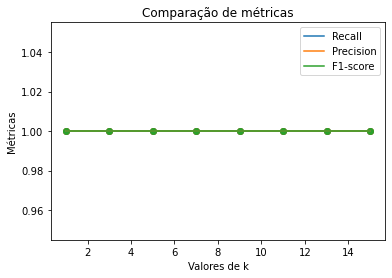

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,5,0
virginica,0,0,6


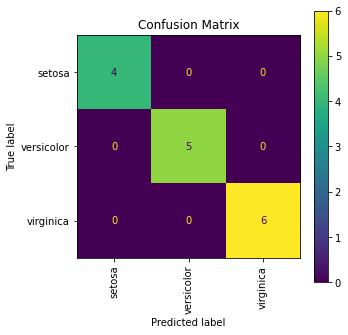

In [175]:
def CV_212(info, metr):
    for k in _k:
        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)

    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def CV_gama(x, y, labels):
    
    kf = k_fold(x, y, 10)
    count = 0
    for info in kf:
        metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
        print("------------------- Iteração " + str(count) + " -------------------")
        count += 1
        new_metr = CV_212(info, metr)

        plot_metricas(new_metr)

        pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
        best_k = _k[pos_k]
        print("Best K: " + str(best_k))

        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], best_k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        mais_bonito(cm, rs, ps, f1, labels)

CV_gama(data, target, iris["target_names"])

### 2.1.3. Bias-Variance e Underfitting-Overfitting

<img src="https://cdn.codespeedy.com/wp-content/uploads/2020/05/Bias-vs-variance.png" width="400">

Sendo que Recall define-se como a métrica que indica a quantidade de entidades relevantes devolvidas, percebemos pela imagem acima que está correlacionada com a Bias. Uma Bias baixa dá um Recall elevado (maior precisão).

Já precisão diz respeito à métrica que indica a quantidade de entidades devolvidas que são efetivamente relevantes. Isto relaciona-se com a variância. Uma variância elevada dá um valor de precisão mais baixo.

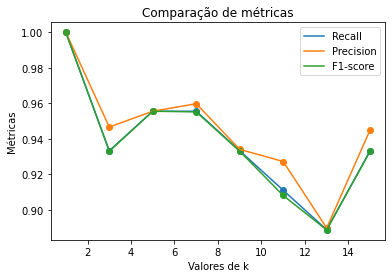

Best K: 1


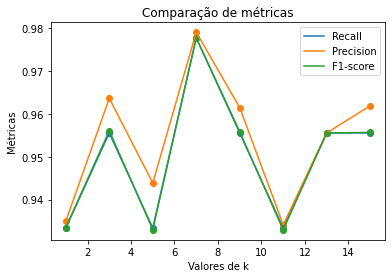

Best K: 7


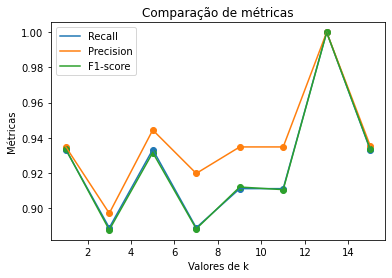

Best K: 13


In [176]:
TVT_gama(data, target, iris["target_names"], printar=False)
TVT_gama(data, target, iris["target_names"], printar=False)
TVT_gama(data, target, iris["target_names"], printar=False)

Analisando os gráficos acima, vemos que a métrica que diz respeito ao Recall está fortemente correlacionada com a Precision. Em todos eles,  para os melhores K, ambas as métricas são elevadas o que nos dá valores de Bias baixa e de Variância elevada. Com isto, os gráficos refletem a imagem seguinte:

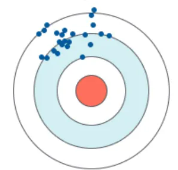

### 2.1.3. Underfitting-Overfitting

### 2.2. ReliefF

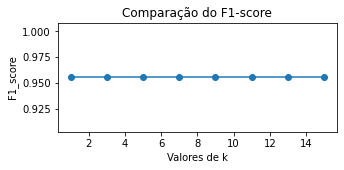

Nr of features: 1
Best K: 1
F1_score: 0.9092929292929294
--------------------------------------------------


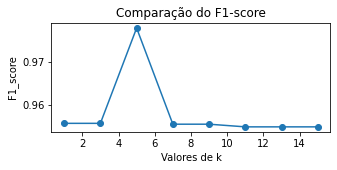

Nr of features: 2
Best K: 5
F1_score: 0.9775795862752384
--------------------------------------------------


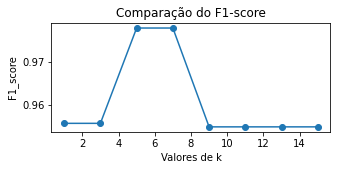

Nr of features: 3
Best K: 5
F1_score: 0.9775795862752384
--------------------------------------------------


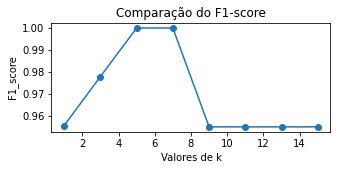

Nr of features: 4
Best K: 5
F1_score: 0.9775795862752384
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.955556,0.955556,0.955556,0.955556,0.955556,0.955556,0.955556,0.955556
Nº of features: 2,0.955754,0.955754,0.977853,0.955556,0.955556,0.954938,0.954938,0.954938
Nº of features: 3,0.955754,0.955754,0.977853,0.977853,0.954938,0.954938,0.954938,0.954938
Nº of features: 4,0.955556,0.977853,1.000000,1.000000,0.954938,0.954938,0.954938,0.954938


In [177]:
def plot_f1(metr_f1):
    plt.figure(figsize=(5,2))

    plt.plot(_k, metr_f1["F1-score"])
    plt.scatter(_k, metr_f1["F1-score"])
    
    plt.title("Comparação do F1-score")
    plt.xlabel("Valores de k")
    plt.ylabel("F1_score")
    plt.show()

def bestkTVT(metr, feat, xTrain, xValidation, trainValidation, s):
    s += 'Nr of features: ' + str(len(feat)) + '\n'
    print('Nr of features: ' + str(len(feat)))
    pos_k = metr["F1-score"].index(max(metr["F1-score"]))
    best_k = _k[pos_k]
    s += "Best K: " + str(best_k) + '\n'
    print("Best K: " + str(best_k))

    newTrain0 = np.concatenate((xTrain, xValidation), axis=0)
    newTrain1 = np.concatenate((trainValidation['TRAIN'][1], trainValidation['VALIDATION'][1]), axis=0)

    neigh = K_neighbors_classifier(newTrain0, newTrain1, best_k)
    xTest = trainValidation['TEST'][0][:,feat]
    pred = neigh.predict(xTest)
    true = trainValidation['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)

    s += 'F1_score: ' + str(f1) + '\n' + '-'*50 + '\n'
    print('F1_score: ' + str(f1))
    print('-'*50)

    return f1, s

def repeatTVT(x, y, featselec, num = 4):

    trainValidation = train_validation_test(x, y, 0.4, 0.3)

    f1_score = []
    f1_score_elbow = []
    str_print = ''

    for f in range(num):
        metr = {"F1-score": []}
        feat = featselec[:(f+1)]
        xTrain = trainValidation['TRAIN'][0][:,feat]
        xValidation = trainValidation['VALIDATION'][0][:,feat]

        for k in _k:
            neigh = K_neighbors_classifier(xTrain, trainValidation['TRAIN'][1], k)
            pred = neigh.predict(xValidation)
            true = trainValidation['VALIDATION'][1]
            cm, rs, ps, f1 = metrics(true, pred)

            metr["F1-score"].append(f1)
        f1_score.append(metr["F1-score"])

        #------------Plot F1-Score--------------------------
        plot_f1(metr)

        #------------Best k--------------------------
        aux, str_print = bestkTVT(metr, feat, xTrain, xValidation, trainValidation, str_print)
        f1_score_elbow.append(aux)

    label = ['Nº of features: ' + str(i+1) for i in range(len(featselec))]
    col = ['k=' + str(i) for i in _k]
    df = pd.DataFrame(f1_score, columns = col, index = label)
    display(df)

    return f1_score_elbow, df, str_print
        

f1_score_elbow, df223, str_print = repeatTVT(data, target, reliefF(data, target))

### 2.2.2 Elbow graph

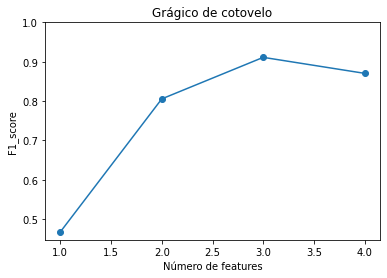

In [202]:
def elbowGraph(lista_f1, num):
    index = np.arange(1,num)

    #plt.figure(figsize=(5,2))
    plt.ylim(min(lista_f1)-0.02,1)

    plt.plot(index, lista_f1)
    plt.scatter(index, lista_f1)
    
    plt.title("Grágico de cotovelo")
    plt.xlabel("Número de features")
    plt.ylabel("F1_score")
    plt.show()

elbowGraph(f1_score_elbow, 5)

### 2.2.3. Validation set results

In [179]:
display(df223)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.955556,0.955556,0.955556,0.955556,0.955556,0.955556,0.955556,0.955556
Nº of features: 2,0.955754,0.955754,0.977853,0.955556,0.955556,0.954938,0.954938,0.954938
Nº of features: 3,0.955754,0.955754,0.977853,0.977853,0.954938,0.954938,0.954938,0.954938
Nº of features: 4,0.955556,0.977853,1.000000,1.000000,0.954938,0.954938,0.954938,0.954938


### 2.2.4. Test set results

In [180]:
print(str_print)

Nr of features: 1
Best K: 1
F1_score: 0.9092929292929294
--------------------------------------------------
Nr of features: 2
Best K: 5
F1_score: 0.9775795862752384
--------------------------------------------------
Nr of features: 3
Best K: 5
F1_score: 0.9775795862752384
--------------------------------------------------
Nr of features: 4
Best K: 5
F1_score: 0.9775795862752384
--------------------------------------------------



### 2.3. Fisher Score

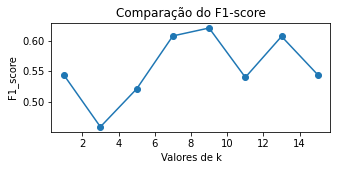

Nr of features: 1
Best K: 9
F1_score: 0.46764705882352947
--------------------------------------------------


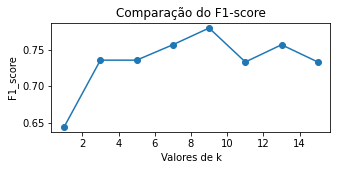

Nr of features: 2
Best K: 9
F1_score: 0.8056100981767181
--------------------------------------------------


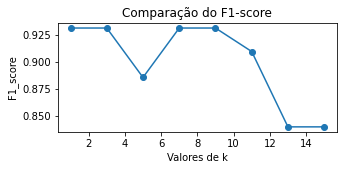

Nr of features: 3
Best K: 1
F1_score: 0.9111111111111111
--------------------------------------------------


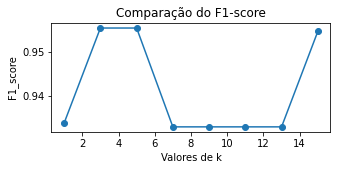

Nr of features: 4
Best K: 3
F1_score: 0.8704545454545455
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.542999,0.458761,0.520842,0.607583,0.620491,0.539767,0.606789,0.543933
Nº of features: 2,0.644444,0.735840,0.735840,0.756948,0.779866,0.733333,0.756948,0.733333
Nº of features: 3,0.931311,0.931311,0.885518,0.931311,0.931311,0.909524,0.839726,0.839726
Nº of features: 4,0.933713,0.955556,0.955556,0.932813,0.932813,0.932813,0.932813,0.954762


In [181]:
score = fisherScore(data, target)

f1_score_elbow, df223, str_print = repeatTVT(data, target, score)


### 2.3.2. Elbow Graph

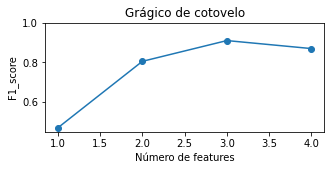

In [182]:
elbowGraph(f1_score_elbow, 5)

### 2.3.3. Validation set results

In [183]:
display(df223)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.542999,0.458761,0.520842,0.607583,0.620491,0.539767,0.606789,0.543933
Nº of features: 2,0.644444,0.735840,0.735840,0.756948,0.779866,0.733333,0.756948,0.733333
Nº of features: 3,0.931311,0.931311,0.885518,0.931311,0.931311,0.909524,0.839726,0.839726
Nº of features: 4,0.933713,0.955556,0.955556,0.932813,0.932813,0.932813,0.932813,0.954762


### 2.3.4. Test set results

In [184]:
print(str_print)

Nr of features: 1
Best K: 9
F1_score: 0.46764705882352947
--------------------------------------------------
Nr of features: 2
Best K: 9
F1_score: 0.8056100981767181
--------------------------------------------------
Nr of features: 3
Best K: 1
F1_score: 0.9111111111111111
--------------------------------------------------
Nr of features: 4
Best K: 3
F1_score: 0.8704545454545455
--------------------------------------------------



### 2.4. Class imbalance

 'target_names': array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [185]:
irisDF = pd.DataFrame(iris.data, columns=iris["feature_names"])
irisDF["target"] = iris["target"]
setosa = irisDF[irisDF["target"] == 0]
versicolor = irisDF[irisDF["target"] == 1].sample(30)
virginica = irisDF[irisDF["target"] == 2].sample(10)
new_iris = pd.concat([setosa, versicolor, virginica], axis=0)
new_iris.groupby("target").count()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
0,50,50,50,50
1,30,30,30,30
2,10,10,10,10


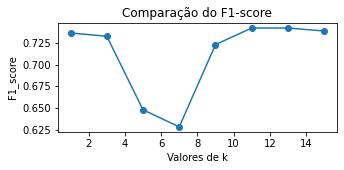

Nr of features: 1
Best K: 11
F1_score: 0.7332585110362889
--------------------------------------------------


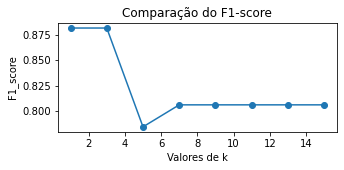

Nr of features: 2
Best K: 1
F1_score: 0.8421052631578947
--------------------------------------------------


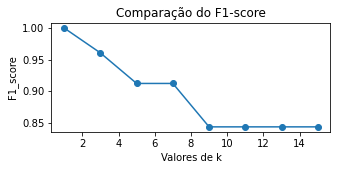

Nr of features: 3
Best K: 1
F1_score: 1.0
--------------------------------------------------


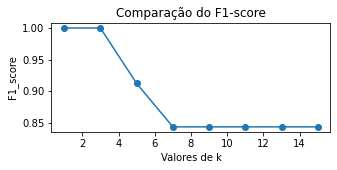

Nr of features: 4
Best K: 1
F1_score: 0.964373897707231
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.736264,0.732510,0.648026,0.628395,0.722897,0.741959,0.741959,0.738562
Nº of features: 2,0.881481,0.881481,0.784480,0.806085,0.806085,0.806085,0.806085,0.806085
Nº of features: 3,1.000000,0.960494,0.912037,0.912037,0.843137,0.843137,0.843137,0.843137
Nº of features: 4,1.000000,1.000000,0.912037,0.843137,0.843137,0.843137,0.843137,0.843137


In [186]:
aux_data = np.array(new_iris.drop(columns=["target"]))
aux_target = np.array(new_iris["target"])

score = fisherScore(aux_data, aux_target)

newIris_elbow, df224, str_print = repeatTVT(aux_data, aux_target, score)

### 2.4.2. Elbow Graph

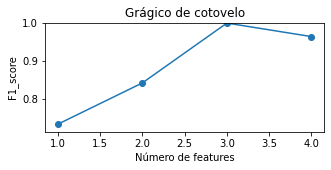

In [187]:
elbowGraph(newIris_elbow, 5)

### 2.4.3. Validation set results

In [188]:
display(df224)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.736264,0.732510,0.648026,0.628395,0.722897,0.741959,0.741959,0.738562
Nº of features: 2,0.881481,0.881481,0.784480,0.806085,0.806085,0.806085,0.806085,0.806085
Nº of features: 3,1.000000,0.960494,0.912037,0.912037,0.843137,0.843137,0.843137,0.843137
Nº of features: 4,1.000000,1.000000,0.912037,0.843137,0.843137,0.843137,0.843137,0.843137


### 2.4.4. Test set results

In [189]:
print(str_print)

Nr of features: 1
Best K: 11
F1_score: 0.7332585110362889
--------------------------------------------------
Nr of features: 2
Best K: 1
F1_score: 0.8421052631578947
--------------------------------------------------
Nr of features: 3
Best K: 1
F1_score: 1.0
--------------------------------------------------
Nr of features: 4
Best K: 1
F1_score: 0.964373897707231
--------------------------------------------------



### 3. ReliefF for dataset of human activity

In [191]:
activities = np.array(['Stand', 'Sit', 'Sit and Talk', 'Walk', 'Walk and Talk', 'Climb Stair (up/down)',
    'Climb Stair (up/down) and talk', 'Stand -> Sit', 'Sit -> Stand', 'Stand -> Sit and talk', 'Sit -> Stand and talk',
    'Stand -> walk', 'Walk -> stand', 'Stand -> climb stairs (up/down)(and talk)', 'Climb stairs (up/down) -> walk',
    'Climb stairs (up/down) and talk -> walk and talk'])
    
Acc_features = pd.read_csv("dataset/Acc_features.csv").drop(columns='Unnamed: 0')
Gyr_features = pd.read_csv("dataset/Gyr_features.csv").drop(columns=['Unnamed: 0','Label'])
Mag_features = pd.read_csv("dataset/Mag_features.csv").drop(columns=['Unnamed: 0', 'Label'])

new_data = pd.concat([Acc_features, Gyr_features, Mag_features], axis=1)
new_data.to_csv('features.csv', encoding='utf-8')
#display(new_data)

display(new_data.groupby("Label").count())

new_target = np.array(new_data["Label"])
feature_data = np.array(new_data.drop(columns = ["Label"]))

,Acc X Mean,Acc X Median,Acc X Std,Acc X Variance,Acc X RMS,Acc X AD,Acc X Skew,Acc X Kurtosis,Acc X IQR,Acc X ZCR,...,Mag Z acc Z Corr,Mag X gyr X Corr,Mag X gyr Y Corr,Mag X gyr Z Corr,Mag Y gyr X Corr,Mag Y gyr Y Corr,Mag Y gyr Z Corr,Mag Z gyr X Corr,Mag Z gyr Y Corr,Mag Z gyr Z Corr
Label,,,,,,,,,,,,,,,,,,,,,
Climb Stair (up/down),1724,1724,1724,1724,1724,1724,1724,1724,1724,1724,...,1724,1724,1724,1724,1724,1724,1724,1724,1724,1724
Climb Stair (up/down) and talk,830,830,830,830,830,830,830,830,830,830,...,830,830,830,830,830,830,830,830,830,830
Climb stairs (up/down) -> walk,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
Climb stairs (up/down) and talk -> walk and talk,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
Sit,1620,1620,1620,1620,1620,1620,1620,1620,1620,1620,...,1620,1620,1620,1620,1620,1620,1620,1620,1620,1620
Sit -> Stand,78,78,78,78,78,78,78,78,78,78,...,78,78,78,78,78,78,78,78,78,78
Sit -> Stand and talk,76,76,76,76,76,76,76,76,76,76,...,76,76,76,76,76,76,76,76,76,76
Sit and Talk,1561,1561,1561,1561,1561,1561,1561,1561,1561,1561,...,1561,1561,1561,1561,1561,1561,1561,1561,1561,1561
Stand,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,...,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917


### 3.1.1. Train-only

,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,1724,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit,0,830,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit and Talk,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,1620,0,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,78,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,0,76,0,0,0,0,0,0,0,0,0
Stand -> Sit,0,0,0,0,0,0,0,1561,0,0,0,0,0,0,0,0
Sit -> Stand,0,0,0,0,0,0,0,0,2917,0,0,0,0,0,0,0
Stand -> Sit and talk,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,0


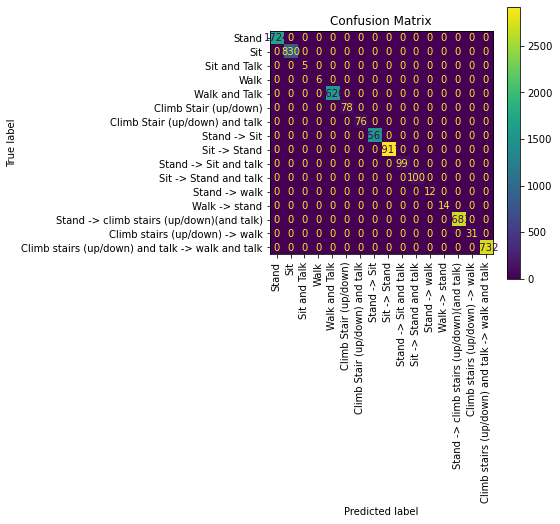

In [192]:
TO_211(feature_data, new_target, activities, 1)

### 3.1.1. TT 70-30

,Metrics
Recall,0.540603
Precision,0.540338
F1-score,0.540243


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,164,64,1,0,0,1,0,0,1,1,2,0,1,127,0,130
Sit,75,36,1,0,0,1,0,0,1,2,0,1,0,84,0,62
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
Walk and Talk,0,0,0,0,358,0,0,125,1,1,3,0,0,0,0,0
Climb Stair (up/down),2,1,0,0,0,3,2,0,13,0,1,0,0,3,0,0
Climb Stair (up/down) and talk,1,2,0,0,0,1,1,1,4,0,1,0,0,4,0,2
Stand -> Sit,0,0,0,0,134,1,2,337,2,5,5,0,0,2,0,0
Sit -> Stand,7,0,0,0,0,9,12,3,816,0,0,0,0,11,7,8
Stand -> Sit and talk,1,0,0,0,6,2,1,5,2,4,3,0,0,2,0,2


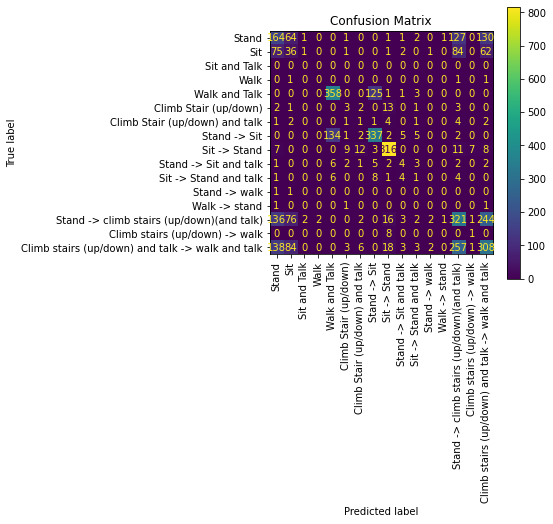

In [193]:
TT_211(feature_data, new_target, activities, 1)

### 3.1.1. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


,Metrics
Recall,0.518979
Precision,0.519373
F1-score,0.518256


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,63,18,1,0,2,0,0,0,0,0,1,0,46,0,40
1,18,7,1,0,0,0,0,0,1,0,0,1,28,0,28
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,114,0,0,56,0,1,1,0,0,0,0,0
4,1,1,0,0,1,2,0,0,0,0,0,0,2,0,0
5,0,0,0,0,1,0,0,5,1,0,0,0,1,0,1
6,0,0,0,42,0,1,98,1,0,0,0,0,0,0,0
7,0,1,0,0,2,3,2,266,1,0,0,0,7,5,4
8,0,0,0,1,1,0,3,3,3,2,0,0,1,0,0
9,4,0,0,1,1,1,4,0,0,0,0,0,3,0,0


------------------- Iteração 1 -------------------


,Metrics
Recall,0.560386
Precision,0.561680
F1-score,0.560454


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,49,11,0,0,0,1,2,0,0,0,1,1,1,48,0,39
Sit,18,11,0,0,0,1,1,0,0,0,0,0,0,20,0,29
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,127,0,0,49,0,2,4,0,0,0,0,0
Climb Stair (up/down),0,1,0,0,0,1,0,0,6,0,1,0,0,0,0,0
Climb Stair (up/down) and talk,1,0,0,0,0,0,1,0,3,0,1,0,0,1,0,1
Stand -> Sit,0,0,0,0,36,0,1,114,0,1,2,0,0,1,0,1
Sit -> Stand,0,0,0,0,0,4,0,0,282,0,1,0,0,7,4,2
Stand -> Sit and talk,0,2,0,0,1,0,0,5,0,1,1,0,0,2,0,1


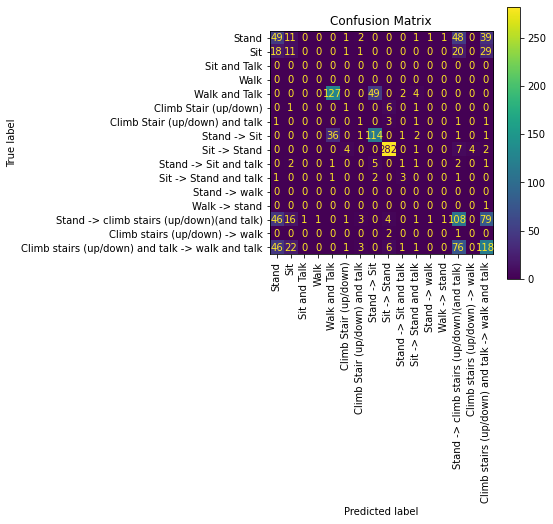

------------------- Iteração 2 -------------------


,Metrics
Recall,0.543133
Precision,0.540151
F1-score,0.540632


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,60,14,1,0,0,0,0,1,1,0,0,2,51,0,40
1,26,11,0,0,0,1,0,0,0,0,0,0,21,0,15
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,114,0,0,49,0,1,0,0,0,0,0,0
4,1,0,0,0,1,2,0,4,0,0,0,0,1,0,0
5,2,0,0,0,0,0,0,2,1,0,0,0,0,0,2
6,0,0,0,37,0,0,128,1,3,1,0,0,0,0,0
7,2,0,0,0,4,1,1,264,1,1,0,0,4,4,2
8,0,0,0,1,0,0,1,1,0,1,0,0,2,0,1
9,0,1,0,4,1,0,5,0,2,2,0,0,1,0,1


------------------- Iteração 3 -------------------


,Metrics
Recall,0.520359
Precision,0.516131
F1-score,0.517664


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,48,21,0,0,0,0,1,1,0,0,0,1,45,0,51
1,24,9,0,0,0,0,0,0,0,0,0,1,27,0,26
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,96,0,0,38,0,2,0,0,0,0,0
5,1,0,0,0,0,1,0,0,4,1,1,0,3,0,1
6,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0
7,0,0,0,0,38,0,0,117,0,0,3,0,0,0,0
8,2,0,0,0,0,5,4,0,276,0,0,0,1,2,2
9,2,1,0,0,2,1,1,3,0,2,2,0,1,0,0


------------------- Iteração 4 -------------------


,Metrics
Recall,0.553485
Precision,0.551301
F1-score,0.552070


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,51,32,0,1,0,0,0,0,0,0,0,0,0,35,0,42
Sit,22,9,0,0,0,0,0,0,0,0,0,0,0,29,0,28
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,119,0,1,46,1,0,2,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,0,0,0,7,0,2,0,0,1,0,1
Climb Stair (up/down) and talk,1,0,0,0,0,0,1,1,3,0,0,0,0,0,0,1
Stand -> Sit,0,0,0,0,37,0,0,128,0,2,4,0,0,1,0,0
Sit -> Stand,0,0,0,0,0,3,2,0,270,0,0,0,0,1,3,3
Stand -> Sit and talk,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0


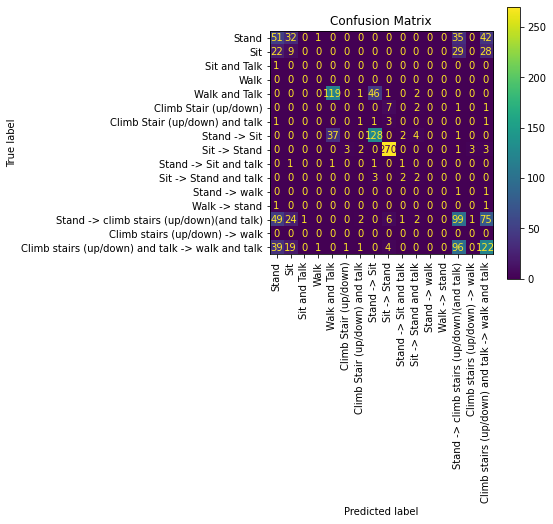

------------------- Iteração 5 -------------------


,Metrics
Recall,0.536232
Precision,0.530932
F1-score,0.533343


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,58,27,1,0,0,1,0,0,1,1,2,0,51,0,40
1,27,13,0,0,0,0,0,0,2,0,0,0,29,0,29
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,111,0,0,39,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
6,0,1,0,0,0,1,0,0,2,1,0,0,0,1,1
7,0,0,0,0,38,2,0,106,3,0,2,0,0,0,0
8,0,0,0,0,0,5,3,0,263,0,0,0,4,1,3
9,1,0,0,0,2,0,0,3,0,2,0,0,0,0,0


------------------- Iteração 6 -------------------


,Metrics
Recall,0.550725
Precision,0.546811
F1-score,0.547554


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,61,34,0,0,2,1,0,1,0,1,0,0,51,0,47
1,26,9,0,0,0,0,0,0,0,0,0,0,21,0,16
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,109,0,0,45,0,1,0,0,0,0,0,0
4,1,0,0,0,1,0,0,7,0,1,0,0,1,0,1
5,1,0,0,0,1,0,0,5,1,0,0,0,1,0,0
6,0,0,0,29,0,0,130,0,0,0,0,0,0,0,0
7,1,1,0,0,2,3,0,274,0,1,0,0,2,1,7
8,0,0,0,1,0,1,4,0,0,1,0,1,2,0,0
9,1,0,0,0,0,0,5,3,0,1,0,1,0,0,1


------------------- Iteração 7 -------------------


,Metrics
Recall,0.550725
Precision,0.551022
F1-score,0.550583


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,56,21,0,0,1,0,0,0,1,2,1,54,0,41
1,18,16,0,0,0,0,0,0,1,0,0,18,0,22
2,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,127,0,0,38,0,0,2,0,0,0,0
4,0,1,0,0,0,0,0,4,0,0,0,0,0,0
5,1,0,0,0,1,0,0,1,0,0,0,4,1,1
6,0,0,0,35,0,0,115,0,0,2,0,0,0,0
7,1,0,0,0,1,3,1,274,1,0,0,7,3,5
8,0,0,0,2,0,0,0,1,1,0,0,1,0,4
9,0,0,0,1,0,0,2,0,0,1,0,1,0,1


------------------- Iteração 8 -------------------


,Metrics
Recall,0.535912
Precision,0.531314
F1-score,0.533250


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,57,22,1,0,0,0,0,0,1,1,0,42,0,51
1,26,8,0,0,1,0,0,0,0,0,0,22,0,28
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,116,0,0,38,0,2,2,0,0,0,0
4,1,0,0,0,0,1,0,1,0,0,0,0,0,0
5,0,1,0,0,2,0,0,2,0,0,0,1,0,2
6,0,0,0,33,0,0,118,0,1,0,0,0,0,0
7,1,0,0,1,3,2,1,258,0,0,0,5,4,3
8,0,0,0,2,0,1,1,1,3,1,0,1,0,2
9,1,0,0,1,0,1,3,0,0,0,0,0,0,0


------------------- Iteração 9 -------------------


,Metrics
Recall,0.560773
Precision,0.562358
F1-score,0.560760


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,69,10,1,1,0,0,0,0,0,0,0,0,0,49,0,39
Sit,27,13,0,0,0,0,1,0,0,1,1,1,0,21,0,20
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,118,0,0,47,1,0,1,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,1,1,2,0,3,0,0,0,0,0,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,0,1,0,3,0,0,0,0,1,0,3
Stand -> Sit,0,0,0,0,35,0,0,111,1,0,0,0,0,1,0,1
Sit -> Stand,0,1,0,0,0,4,5,0,304,0,1,0,0,4,1,3
Stand -> Sit and talk,0,1,0,0,2,0,1,0,0,2,0,0,0,0,0,1


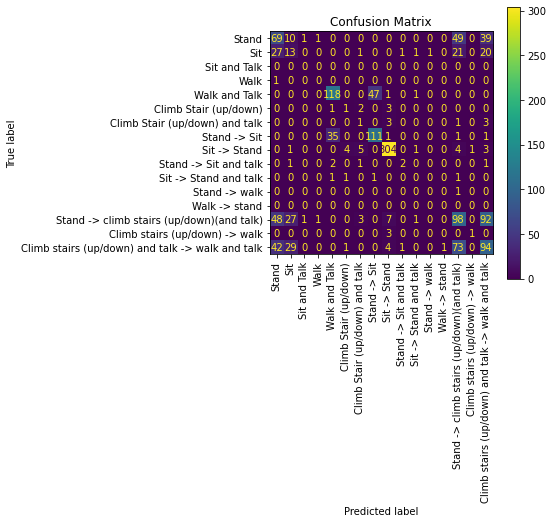

In [194]:
CV_211(feature_data, new_target, 10, activities, 1)

### 3.1.2. Train-only

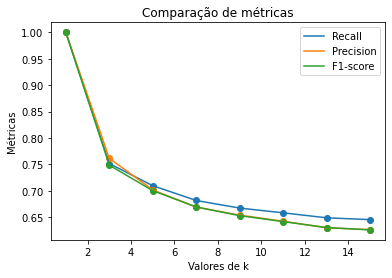

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,1724,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit,0,830,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit and Talk,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,1620,0,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,78,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,0,76,0,0,0,0,0,0,0,0,0
Stand -> Sit,0,0,0,0,0,0,0,1561,0,0,0,0,0,0,0,0
Sit -> Stand,0,0,0,0,0,0,0,0,2917,0,0,0,0,0,0,0
Stand -> Sit and talk,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,0


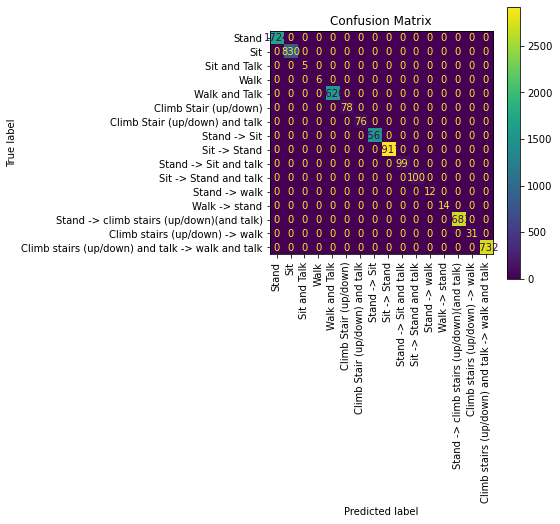

In [195]:
TO_gama(feature_data, new_target, activities)

### 3.1.2. TVT 40-30-30

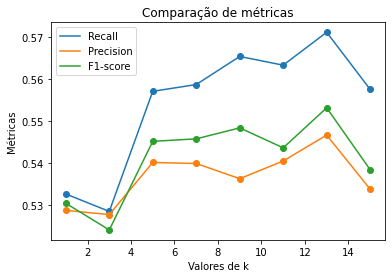

Best K: 13


,Metrics
Recall,0.585921
Precision,0.558535
F1-score,0.567546


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,264,18,0,0,0,0,0,0,1,2,0,0,147,0,108
1,86,12,0,0,0,0,0,0,0,0,0,0,71,0,77
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,340,0,0,175,3,0,1,0,0,0,0,0
4,4,0,0,0,0,0,0,15,1,0,0,0,3,0,0
5,2,0,0,0,0,0,0,12,3,0,0,0,4,0,2
6,0,0,0,118,1,0,338,12,0,1,0,0,1,0,0
7,0,0,0,1,2,0,4,847,0,0,0,0,10,0,1
8,1,1,0,7,2,0,7,1,2,0,0,0,4,0,3
9,1,2,0,4,0,0,8,7,1,0,0,0,4,0,1


In [196]:
TVT_gama(feature_data, new_target, activities)

### 3.1.2. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


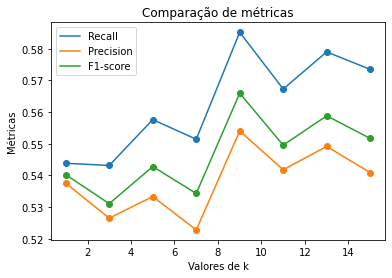

Best K: 9


,Metrics
Recall,0.585231
Precision,0.554013
F1-score,0.565969


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,85,8,0,0,0,0,0,0,0,0,0,0,0,47,0,45
Sit,28,3,0,0,0,0,0,0,1,1,0,0,0,33,0,19
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,115,0,0,53,0,0,0,0,0,0,0,0
Climb Stair (up/down),2,0,0,0,0,1,1,0,3,0,0,0,0,1,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,0,0,0,6,1,0,0,0,0,0,0
Stand -> Sit,0,0,0,0,39,0,0,131,3,0,0,0,0,0,0,0
Sit -> Stand,2,0,0,0,0,0,0,0,276,0,0,0,0,1,0,1
Stand -> Sit and talk,0,0,0,0,0,0,0,4,1,1,0,0,0,3,0,1


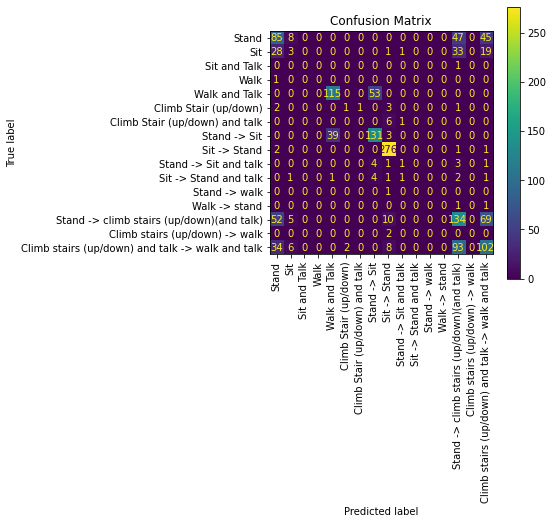

------------------- Iteração 1 -------------------


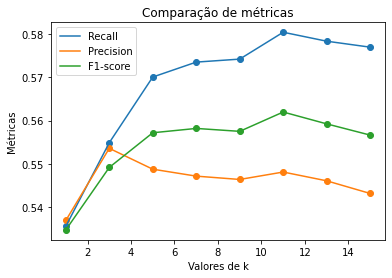

Best K: 11


,Metrics
Recall,0.580400
Precision,0.548088
F1-score,0.561960


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,73,8,0,0,0,0,0,0,0,1,0,0,0,56,0,29
Sit,23,2,0,0,0,0,0,0,0,0,0,0,0,31,0,18
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk and Talk,0,0,0,0,104,0,0,49,2,1,1,0,0,0,0,0
Climb Stair (up/down),1,0,0,0,0,0,0,0,6,0,0,0,0,0,0,1
Climb Stair (up/down) and talk,1,0,0,0,1,0,0,0,5,1,1,0,0,4,0,0
Stand -> Sit,0,0,0,0,33,0,0,117,4,2,0,0,0,0,0,0
Sit -> Stand,1,0,0,0,0,0,1,1,287,0,0,0,0,3,0,2
Stand -> Sit and talk,0,0,0,0,0,0,0,3,0,1,1,0,0,1,0,0


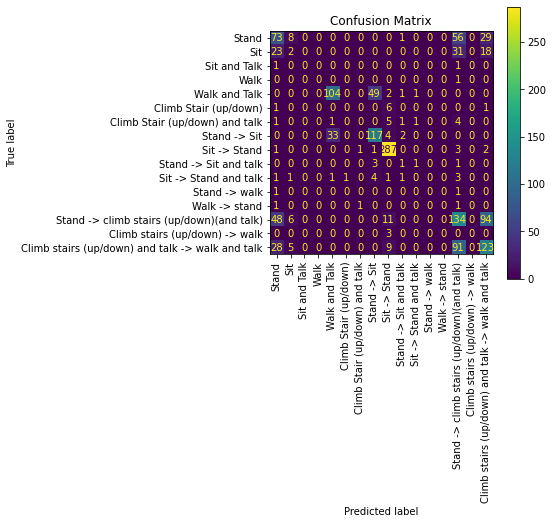

------------------- Iteração 2 -------------------


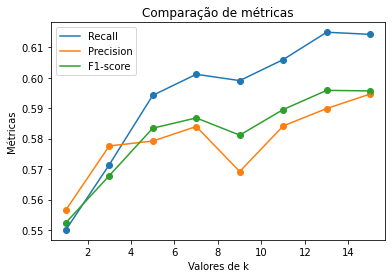

Best K: 13


,Metrics
Recall,0.614907
Precision,0.589869
F1-score,0.595834


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,69,7,0,0,0,0,0,0,0,0,0,43,0,47
1,24,3,0,0,0,0,0,0,0,0,0,28,0,24
2,0,0,114,0,0,57,1,0,0,0,0,0,0,0
3,2,0,0,0,0,0,7,2,0,0,0,2,0,0
4,1,0,0,0,0,0,1,0,0,0,0,1,0,2
5,0,0,33,0,0,124,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,293,1,0,0,0,4,0,1
7,0,0,2,1,0,2,1,1,0,0,0,2,0,1
8,1,0,1,1,0,3,1,1,1,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0


------------------- Iteração 3 -------------------


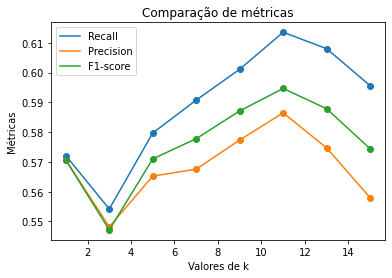

Best K: 11


,Metrics
Recall,0.613527
Precision,0.586466
F1-score,0.594658


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,84,4,0,0,0,0,0,0,0,0,0,0,51,0,38
1,30,3,0,0,0,0,0,0,0,0,0,0,22,0,21
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,114,0,0,45,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,4,0,0,0,0,2,0,0
5,1,0,0,0,0,0,0,2,0,0,0,0,1,0,1
6,0,0,0,39,0,0,125,3,0,0,0,0,0,0,0
7,0,0,0,1,0,0,1,294,0,0,0,0,0,0,1
8,0,0,0,2,0,0,0,1,0,1,0,0,2,0,1
9,2,1,0,1,0,0,4,4,0,0,0,0,2,0,1


------------------- Iteração 4 -------------------


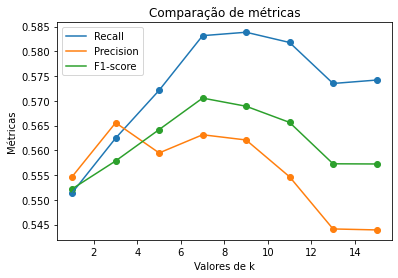

Best K: 7


,Metrics
Recall,0.583161
Precision,0.563137
F1-score,0.570547


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,86,11,0,0,0,0,0,0,1,0,38,0,48
1,29,3,0,0,0,0,0,0,0,0,13,0,24
2,0,0,122,0,0,39,0,0,0,0,0,0,0
3,0,0,0,1,0,0,2,1,0,0,0,0,0
4,0,0,0,0,0,1,5,0,0,0,2,0,1
5,0,0,38,0,0,131,1,0,0,0,1,0,0
6,2,0,0,1,0,2,277,0,0,0,1,0,2
7,0,1,3,1,3,2,0,1,0,0,0,0,1
8,1,0,1,0,0,2,1,0,0,0,1,0,0
9,0,0,0,0,0,0,1,0,0,0,0,0,0


------------------- Iteração 5 -------------------


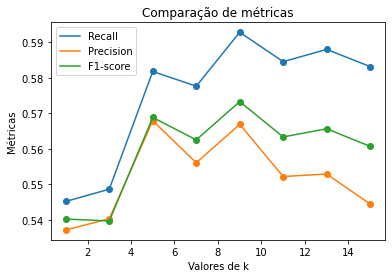

Best K: 9


,Metrics
Recall,0.592823
Precision,0.566911
F1-score,0.573299


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,88,4,0,0,0,0,0,0,0,0,45,0,31
1,43,4,0,0,0,0,0,1,0,0,26,0,23
2,0,0,114,0,0,42,2,0,0,0,0,0,0
3,0,1,0,1,0,0,5,0,0,0,0,0,1
4,0,0,0,0,0,0,3,0,0,0,4,0,1
5,0,0,34,0,0,97,2,1,0,0,0,0,0
6,0,0,0,0,0,1,285,0,0,0,3,0,1
7,2,0,3,0,2,2,1,0,0,0,0,0,2
8,1,1,2,0,0,2,1,1,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,1,0,2


------------------- Iteração 6 -------------------


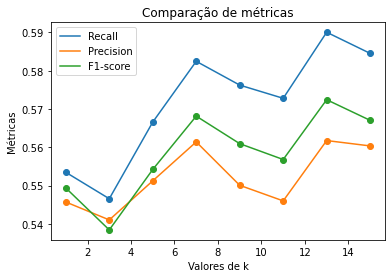

Best K: 13


,Metrics
Recall,0.590062
Precision,0.561775
F1-score,0.572443


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,86,8,0,0,1,0,0,0,0,0,40,0,38
1,24,3,0,0,0,0,0,0,0,0,24,0,26
2,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,103,0,0,39,0,0,0,0,0,0
4,0,0,0,0,0,0,0,5,0,0,0,0,0
5,0,1,0,0,0,0,0,6,1,0,0,0,0
6,0,0,0,37,0,0,98,0,0,0,0,0,0
7,1,0,0,2,1,0,1,297,0,0,1,0,2
8,0,1,0,1,2,0,3,1,0,1,0,0,1
9,1,0,0,0,0,0,7,0,0,1,2,0,0


------------------- Iteração 7 -------------------


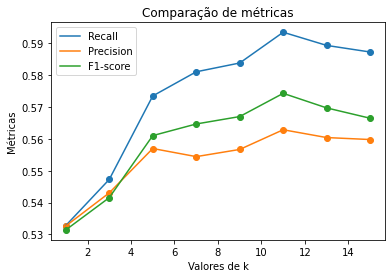

Best K: 11


,Metrics
Recall,0.593513
Precision,0.562878
F1-score,0.574315


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,85,8,0,0,0,0,0,0,0,0,0,0,46,0,42
1,36,4,0,0,1,0,0,0,0,0,0,0,24,0,27
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,116,0,0,39,0,0,2,0,0,0,0,0
4,0,0,0,0,0,0,0,6,0,0,0,0,4,0,0
5,0,0,0,0,0,0,0,6,1,0,0,0,0,0,0
6,0,0,0,31,1,0,116,6,0,0,0,0,0,0,0
7,1,0,0,2,1,0,0,279,0,0,0,0,3,0,1
8,0,1,0,2,0,0,4,0,0,0,0,0,2,0,1
9,0,2,0,0,0,0,3,1,0,0,0,0,1,0,0


------------------- Iteração 8 -------------------


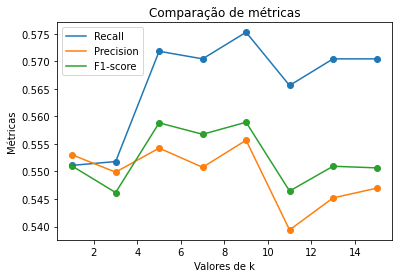

Best K: 9


,Metrics
Recall,0.575276
Precision,0.555664
F1-score,0.558936


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,71,5,0,0,1,0,0,0,0,0,0,43,0,39
1,36,9,0,0,0,0,0,0,0,0,0,33,0,22
2,0,0,0,0,0,0,0,0,0,0,0,2,0,0
3,0,0,0,127,0,0,52,2,0,0,0,0,0,0
4,0,0,0,0,1,0,0,7,0,0,0,0,0,0
5,2,0,0,0,0,0,0,3,1,0,0,1,0,1
6,0,0,0,47,0,0,105,2,1,0,0,0,0,0
7,0,1,0,1,1,0,0,278,0,0,0,3,0,1
8,1,0,0,3,2,1,1,0,0,0,0,1,0,1
9,0,0,0,1,0,0,3,2,1,0,0,2,0,0


------------------- Iteração 9 -------------------


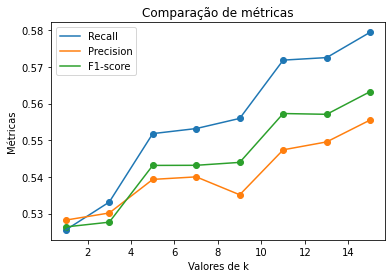

Best K: 15


,Metrics
Recall,0.579420
Precision,0.555502
F1-score,0.563237


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,72,6,0,0,0,0,0,0,0,0,0,44,0,42
1,30,5,0,0,0,0,0,0,0,0,0,25,0,21
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,112,0,0,51,1,1,0,0,0,0,0
4,1,0,0,0,0,0,0,4,0,0,0,1,0,0
5,0,0,0,0,0,0,0,2,1,0,0,3,0,0
6,0,0,0,38,0,0,117,2,0,0,0,1,0,0
7,0,0,0,1,0,0,0,285,0,0,0,8,0,0
8,1,1,0,2,0,0,1,3,0,1,0,3,0,0
9,0,0,0,0,0,0,5,1,1,0,0,3,0,0


In [197]:
CV_gama(feature_data, new_target, activities)

### 3.2. ReliefF

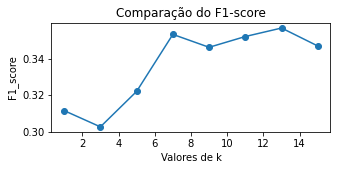

Nr of features: 1
Best K: 13
F1_score: 0.34586153808148007
--------------------------------------------------


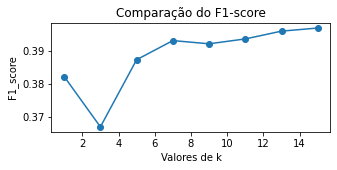

Nr of features: 2
Best K: 15
F1_score: 0.39571139457249604
--------------------------------------------------


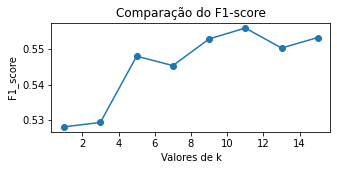

Nr of features: 3
Best K: 11
F1_score: 0.5714746387418289
--------------------------------------------------


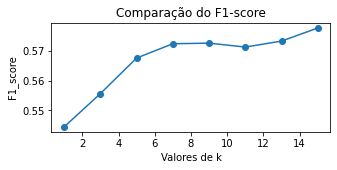

Nr of features: 4
Best K: 15
F1_score: 0.5820481968840711
--------------------------------------------------


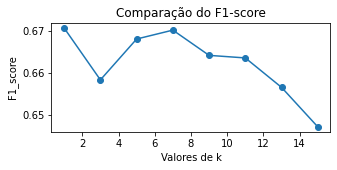

Nr of features: 5
Best K: 1
F1_score: 0.6903343785690187
--------------------------------------------------


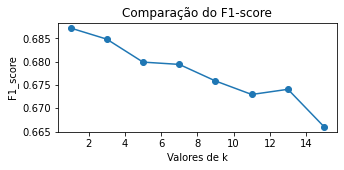

Nr of features: 6
Best K: 1
F1_score: 0.7101102768347458
--------------------------------------------------


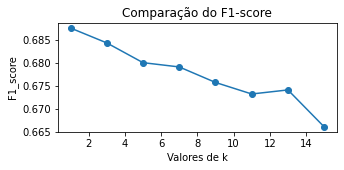

Nr of features: 7
Best K: 1
F1_score: 0.7100999166000601
--------------------------------------------------


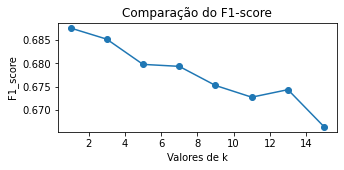

Nr of features: 8
Best K: 1
F1_score: 0.7103594815207049
--------------------------------------------------


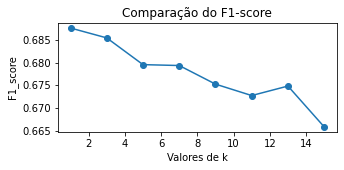

Nr of features: 9
Best K: 1
F1_score: 0.7103594815207049
--------------------------------------------------


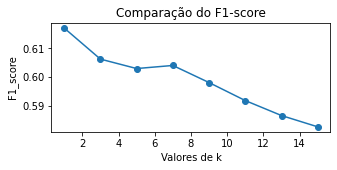

Nr of features: 10
Best K: 1
F1_score: 0.6395637251811308
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.311583,0.302646,0.322161,0.353525,0.346421,0.352355,0.357026,0.347138
Nº of features: 2,0.382299,0.367088,0.387377,0.393155,0.392189,0.393660,0.396013,0.396954
Nº of features: 3,0.528122,0.529370,0.548043,0.545396,0.552899,0.555982,0.550340,0.553308
Nº of features: 4,0.544506,0.555642,0.567571,0.572355,0.572560,0.571239,0.573261,0.577623
Nº of features: 5,0.670801,0.658396,0.668172,0.670300,0.664263,0.663647,0.656605,0.647162
Nº of features: 6,0.687244,0.684858,0.679928,0.679437,0.675881,0.672982,0.674092,0.666033
Nº of features: 7,0.687672,0.684416,0.680097,0.679160,0.675771,0.673246,0.674135,0.666059
Nº of features: 8,0.687615,0.685219,0.679797,0.679370,0.675263,0.672741,0.674357,0.666359
Nº of features: 9,0.687652,0.685468,0.679567,0.679370,0.675263,0.672741,0.674837,0.665827
Nº of features: 10,0.617108,0.606273,0.602984,0.604059,0.598090,0.591817,0.586597,0.582660


In [206]:
newActivity_elbow, df3, str_print = repeatTVT(feature_data,new_target, reliefF(feature_data, new_target), 10)

### 3.2. Elbow Graph

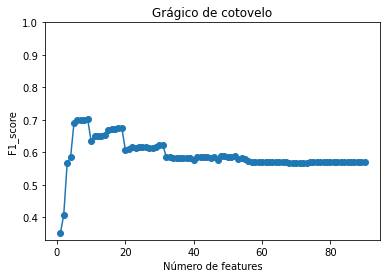

In [203]:
elbowGraph(newActivity_elbow, 11)

### 3.3. Validation set results

In [ ]:
display(df3)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.301690,0.307166,0.303531,0.319016,0.335253,0.342293,0.334984,0.335001
Nº of features: 2,0.365369,0.361148,0.386993,0.392844,0.394149,0.397750,0.391162,0.396056
Nº of features: 3,0.528470,0.556741,0.559518,0.571974,0.576977,0.576004,0.570724,0.573679
Nº of features: 4,0.543928,0.569740,0.576988,0.582966,0.585480,0.586223,0.582825,0.576937
Nº of features: 5,0.684389,0.685085,0.686717,0.678018,0.675778,0.674702,0.669558,0.661558
Nº of features: 6,0.699023,0.702023,0.700242,0.695441,0.688184,0.685357,0.685521,0.680592
Nº of features: 7,0.698502,0.702674,0.699602,0.695903,0.687897,0.685357,0.685447,0.680688
Nº of features: 8,0.699438,0.702734,0.700190,0.696011,0.688309,0.685514,0.685649,0.681536
Nº of features: 9,0.700172,0.702326,0.700357,0.695674,0.688068,0.685614,0.685649,0.681935
Nº of features: 10,0.626329,0.618625,0.623272,0.612498,0.609585,0.604300,0.598878,0.594261


### 3.4. Test set results

In [ ]:
print(str_print)

Nr of features: 1
Best K: 11
F1_score: 0.33444806820998135
--------------------------------------------------
Nr of features: 2
Best K: 11
F1_score: 0.4039188069247232
--------------------------------------------------
Nr of features: 3
Best K: 9
F1_score: 0.5725471258591016
--------------------------------------------------
Nr of features: 4
Best K: 11
F1_score: 0.5874129769870751
--------------------------------------------------
Nr of features: 5
Best K: 5
F1_score: 0.6895626295297461
--------------------------------------------------
Nr of features: 6
Best K: 3
F1_score: 0.708298721064873
--------------------------------------------------
Nr of features: 7
Best K: 3
F1_score: 0.7082939727138443
--------------------------------------------------
Nr of features: 8
Best K: 3
F1_score: 0.7082522675197038
--------------------------------------------------
Nr of features: 9
Best K: 3
F1_score: 0.7082832407146131
--------------------------------------------------
Nr of features: 10
Best K

### 4. Neural net

In [279]:
from sklearn.neural_network import MLPClassifier

dataTVT = train_validation_test(feature_data, new_target, 0.4, 0.3)

def plot_f1_2(metr, neur_evol):
    plt.figure()

    plt.plot(neur_evol, metr, label="f1")
    plt.scatter(neur_evol, metr)
    
    plt.title("Evolução do f1-score")
    plt.xlabel("Número de neurónios")
    plt.ylabel("f1-score")
    plt.show()

### 4.1. Fixed learning speed

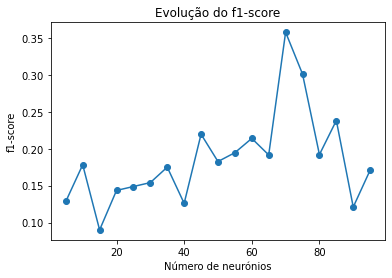

Best neurons number: 70


TypeError: only integer scalar arrays can be converted to a scalar index

In [289]:
from sklearn.preprocessing import StandardScaler  

def mlp_4(type_speed):
    nns = []
    metrF1 = []

    neur_evol = np.arange(5, 100, 5)

    for i in neur_evol:
        if type_speed == 'fixed':
            clf = MLPClassifier(activation='logistic', solver='sgd', learning_rate_init=0.1, hidden_layer_sizes=i, max_iter=2000)
        elif type_speed == 'variable':
            clf = MLPClassifier(activation='logistic', learning_rate='invscaling', solver='sgd', learning_rate_init=0.1, hidden_layer_sizes=i, max_iter=2000)
        else:
             clf = MLPClassifier(activation='logistic', hidden_layer_sizes=i, solver='sgd', learning_rate_init=0.1, momentum=0.5, max_iter=2000)
        
        nns.append(clf.fit(dataTVT["TRAIN"][0], dataTVT["TRAIN"][1]))

        pred = clf.predict(dataTVT["VALIDATION"][0])

        true = dataTVT['VALIDATION'][1]
        
        cm, rs, ps, f1 = metrics(true, pred)

        metrF1.append(f1)

    plot_f1_2(metrF1, neur_evol)

    print("Best neurons number: " + str(neur_evol[np.argmax(metrF1)]))

    best_nns = np.argmax(metrF1)
    n_neur = neur_evol[best_nns]

    data_fin_x = np.concatenate(dataTVT["TRAIN"][0], dataTVT["VALIDATION"][0])
    data_fin_y = np.concatenate(dataTVT["TRAIN"][1], dataTVT["VALIDATION"][1])

    if type_speed == 'fixed':
        clf = MLPClassifier(activation='logistic', solver='sgd', learning_rate_init=0.1, hidden_layer_sizes=n_neur, max_iter=2000)
    elif type_speed == 'variable':
        clf = MLPClassifier(activation='logistic', learning_rate='invscaling', solver='sgd', learning_rate_init=0.1, hidden_layer_sizes=n_neur, max_iter=2000)
    else:
        clf = MLPClassifier(activation='logistic', hidden_layer_sizes=n_neur, solver='sgd', learning_rate_init=0.1, momentum=0.5, max_iter=2000)

    clf.fit(data_fin_x, data_fin_y)

    pred = clf.predict(dataTVT["TEST"][0])
    true = dataTVT['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    mais_bonito(cm, rs, ps, f1, activities)

mlp_4('fixed')


### 4.2. Variable learning speed

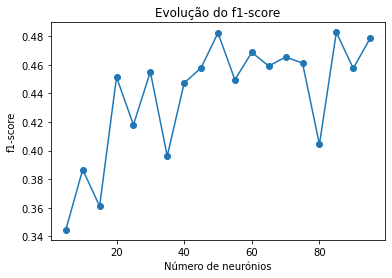

Best neurons number: 85


,Metrics
Recall,0.547964
Precision,0.486902
F1-score,0.499698


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,285,0,0,0,0,0,0,0,0,0,0,0,0,42,0,194
Sit,133,0,0,0,0,0,0,0,0,0,0,0,0,17,0,111
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Walk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Walk and Talk,0,0,0,0,330,0,0,162,0,0,0,0,0,3,0,0
Climb Stair (up/down),4,0,0,0,0,0,0,0,10,0,0,0,0,4,0,4
Climb Stair (up/down) and talk,2,0,0,0,0,0,0,0,9,0,0,0,0,6,0,4
Stand -> Sit,0,0,0,0,190,0,0,233,1,0,0,0,0,6,0,1
Sit -> Stand,9,0,0,0,0,0,0,0,865,0,0,0,0,27,0,6
Stand -> Sit and talk,3,0,0,0,4,0,0,6,0,0,0,0,0,13,0,3


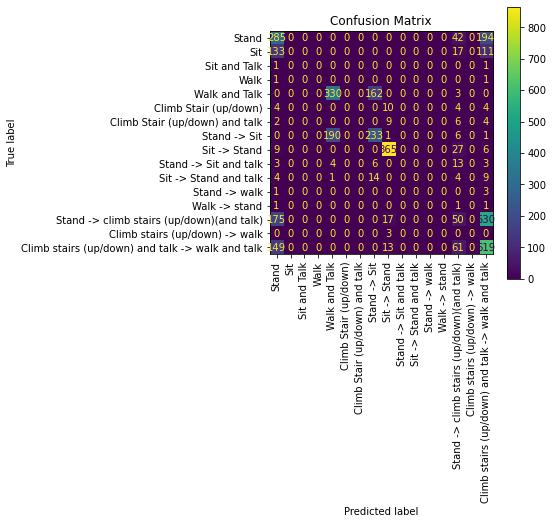

In [ ]:
mlp_4('variable')

### 4.3. Momentum coeficient

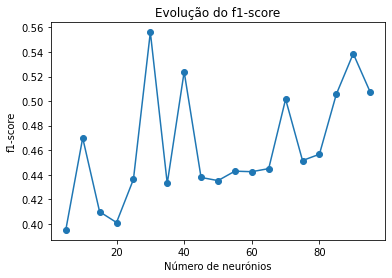

Best neurons number: 30


,Metrics
Recall,0.579250
Precision,0.544024
F1-score,0.556613


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,239,0,0,0,0,0,0,0,0,0,0,0,0,149,0,133
Sit,99,0,0,0,0,0,0,0,0,0,0,0,0,101,0,61
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk and Talk,0,0,0,0,427,0,0,67,0,0,0,0,0,1,0,0
Climb Stair (up/down),4,0,0,0,0,0,0,0,12,0,0,0,0,5,0,1
Climb Stair (up/down) and talk,4,0,0,0,0,0,0,0,9,0,0,0,0,7,0,1
Stand -> Sit,3,0,0,0,138,0,0,284,2,0,0,0,0,1,0,3
Sit -> Stand,17,0,0,0,0,0,0,0,875,0,0,0,0,14,0,1
Stand -> Sit and talk,6,0,0,0,7,0,0,5,0,0,0,0,0,8,0,3


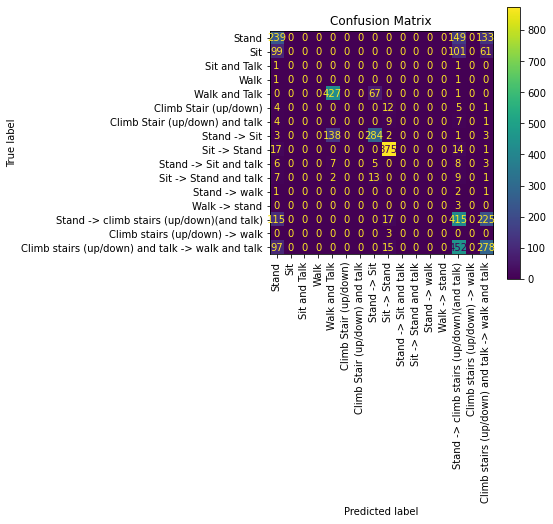

In [ ]:
mlp_4('momentum')

### 5. Neural net from scratch

In [ ]:
class MLP():
    def __init__(self, x, y, hidden_layers, num_outputs, printar = False):
        """
            num_inputs (int): Number of inputs
            hidden_layers (list): A list of ints for the hidden layers
            num_outputs (int): Number of outputs
        """
        self.x = x
        self.y = y
        self.printar = printar
        self.num_inputs = self.x.shape[1]
        self.hidden_layers = hidden_layers
        self.num_outputs = num_outputs

        layers = [self.x.shape[1]] + hidden_layers + [num_outputs] # create a generic representation of the layers

        # create random connection weights for the layers
        weights = []
        for i in range(len(layers) - 1):
            weights.append(np.random.rand(layers[i], layers[i + 1]))
        self.weights = weights

        # save derivatives per layer
        derivatives = []
        for i in range(len(layers) - 1):
            derivatives.append(np.zeros((layers[i], layers[i + 1])))
        self.derivatives = derivatives

        # save activations per layer
        activations = []
        for i in range(len(layers)):
            activations.append(np.zeros(layers[i]))

        self.activations = activations


    def _feedforward(self, inputs):
        """
        Args:
            inputs (ndarray): Input signals
        Returns:
            activations (ndarray): Output values
        """

        activations = inputs # the input layer activation is just the input itself

        self.activations[0] = activations # save the activations for backpropogation

        # iterate through the network layers
        for i, w in enumerate(self.weights):
            net_inputs = np.dot(activations, w) # calculate matrix multiplication between previous activation and weight matrix
            activations = self._sigmoid(net_inputs) # apply sigmoid activation function
            self.activations[i + 1] = activations # save the activations for backpropogation

        return activations # return output layer activation


    def _backprop(self, error):
        """
        Args:
            error (ndarray): The error to backprop.
        Returns:
            error (ndarray): The final error of the input
        """

        # iterate backwards through the network layers
        for i in reversed(range(len(self.derivatives))):

            activations = self.activations[i+1] # get activation for previous layer

            delta = error * self._sigmoid_derivative(activations) # apply sigmoid derivative function
            delta_re = delta.reshape(delta.shape[0], -1).T # reshape delta as to have it as a 2d array
            current_activations = self.activations[i] # get activations for current layer

            current_activations = current_activations.reshape(current_activations.shape[0],-1) # reshape activations as to have them as a 2d column matrix

            self.derivatives[i] = np.dot(current_activations, delta_re) # save derivative after applying matrix multiplication

            error = np.dot(delta, self.weights[i].T) # backpropogate the next error


    def fit(self, epochs, learning_rate):
        """
        Args:
            inputs (ndarray): X
            targets (ndarray): Y
            epochs (int): Num. epochs we want to train the network for
            learning_rate (float): Step to apply to gradient descent
        """
        # now enter the training loop
        for i in range(epochs):
            sum_errors = 0

            # iterate through all the training data
            for input, targetY in zip(self.x, self.y):
                
                output = self._feedforward(input) # activate the network!
                error = targetY - output

                self._backprop(error)

                self.gradient_descent(learning_rate) # now perform gradient descent on the derivatives -> this will update the weights
                
                sum_errors += np.average((targetY - output) ** 2) # keep track of the MSE for reporting later

            if self.printar: # Epoch complete, report the training error
                print("Error: {} at epoch {}".format(sum_errors / len(self.x), i+1))

    def predict(self,test):
        if self.num_outputs == 1: 
            return np.array([self._feedforward(t) for t in test])
        else:
            output = []
            for t in test:
                pred = list(self._feedforward(t))
                # maximo dos nos do output
                output.append(pred.index(max(pred)))
            return np.array(output)

    def gradient_descent(self, learningRate=1):
        """
        Args:
            learningRate (float): How fast to learn.
        """
        # update the weights by stepping down the gradient
        for i in range(len(self.weights)):
            weights = self.weights[i]
            derivatives = self.derivatives[i]
            weights += derivatives * learningRate


    def _sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))


    def _sigmoid_derivative(self, x):
        return x * (1.0 - x)

In [ ]:
def change(type):
    dataTVT[type][1][dataTVT[type][1] == "Stand"] = 0
    dataTVT[type][1][dataTVT[type][1] == "Sit"] = 1
    dataTVT[type][1][dataTVT[type][1] == "Sit and Talk"] = 2
    dataTVT[type][1][dataTVT[type][1] == "Walk"] = 3
    dataTVT[type][1][dataTVT[type][1] == "Walk and Talk"] = 4
    dataTVT[type][1][dataTVT[type][1] == "Climb Stair (up/down)"] = 5
    dataTVT[type][1][dataTVT[type][1] == "Climb Stair (up/down) and talk"] = 6
    dataTVT[type][1][dataTVT[type][1] == "Stand -> Sit"] = 7
    dataTVT[type][1][dataTVT[type][1] == "Sit -> Stand"] = 8
    dataTVT[type][1][dataTVT[type][1] == "Stand -> Sit and talk"] = 9
    dataTVT[type][1][dataTVT[type][1] == "Sit -> Stand and talk"] = 10
    dataTVT[type][1][dataTVT[type][1] == "Stand -> walk"] = 11
    dataTVT[type][1][dataTVT[type][1] == "Walk -> stand"] = 12
    dataTVT[type][1][dataTVT[type][1] == "Stand -> climb stairs (up/down)(and talk)"] = 13
    dataTVT[type][1][dataTVT[type][1] == "Climb stairs (up/down) -> walk"] = 14
    dataTVT[type][1][dataTVT[type][1] == "Climb stairs (up/down) and talk -> walk and talk"] = 15

    dataTVT[type][1] = dataTVT[type][1].astype('float64')
    


Número de neurónios:  5
Número de neurónios:  10
Número de neurónios:  15
Número de neurónios:  20
Número de neurónios:  25
Número de neurónios:  30
Número de neurónios:  35
Número de neurónios:  40
Número de neurónios:  45
Número de neurónios:  50
Número de neurónios:  55
Número de neurónios:  60
Número de neurónios:  65
Número de neurónios:  70
Número de neurónios:  75
Número de neurónios:  80
Número de neurónios:  85
Número de neurónios:  90
Número de neurónios:  95


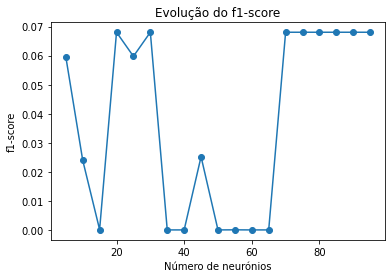

Best neurons number: 20


,Metrics
Recall,0.195997
Precision,0.038415
F1-score,0.064239


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,852,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,466,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,494,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,807,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,834,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,501,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,273,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
dataTVT = train_validation_test(feature_data, new_target, 0.4, 0.3)

def mlp_5():
    nns = []
    metrF1 = []

    neur_evol = np.arange(5, 100, 5)

    
    for i in neur_evol:
        print("Número de neurónios: ", i)
        clf = MLP(dataTVT["TRAIN"][0], dataTVT["TRAIN"][1], hidden_layers=[i], num_outputs=16)
        clf.fit(epochs=100, learning_rate=0.1)
        
        nns.append(clf)
        
        pred = clf.predict(dataTVT["VALIDATION"][0])

        true = dataTVT["VALIDATION"][1]        
        
        cm, rs, ps, f1 = metrics(true, pred)

        metrF1.append(f1)

    plot_f1_2(metrF1, neur_evol)

    print("Best neurons number: " + str(neur_evol[np.argmax(metrF1)]))

    best_nns = nns[np.argmax(metrF1)]
    pred = best_nns.predict(dataTVT["TEST"][0])
    true = dataTVT['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    mais_bonito(cm, rs, ps, f1, activities)
    

change("TRAIN")
change("TEST")
change("VALIDATION")
mlp_5()


In [273]:
class NeuralNetwork:
    def __init__(self, x, y, nr_neuronios, nr_fet):
        self.input      = x
        self.weights1   = np.random.rand(self.input.shape[1], nr_neuronios) 
        self.weights2   = np.random.rand(nr_neuronios, nr_fet)                 
        self.y          = y
        self.output     = np.zeros(self.y.shape)

    def feedforward(self):
        self.layer1 = self.sigmoid(np.dot(self.input, self.weights1))
        self.output = self.sigmoid(np.dot(self.layer1, self.weights2))

    def backprop(self):
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output) * self.sigmoid_derivative(self.output)))
        d_weights1 = np.dot(self.input.T,  (np.dot(2*(self.y - self.output) * self.sigmoid_derivative(self.output), self.weights2.T) * self.sigmoid_derivative(self.layer1)))

        # update the weights with the derivative (slope) of the loss function
        self.weights1 += d_weights1
        self.weights2 += d_weights2

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))


    def sigmoid_derivative(self, x):
        return x * (1.0 - x)

,Metrics
Recall,0.813333
Precision,0.833333
F1-score,0.815740


,setosa,versicolor,virginica
setosa,49,0,0
versicolor,1,30,7
virginica,0,20,43


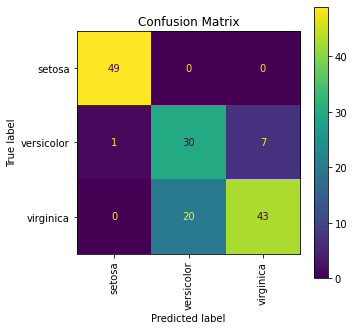

In [259]:
iris = datasets.load_iris()

data = iris.data
for i in range(data.shape[1]):
    data[:,i] = (data[:,i] - data[:,i].mean()) / data[:,i].std()

target = iris.target
matriz_bin = np.zeros((len(target),3))
for i in range(len(matriz_bin)):
    matriz_bin[i, target[i]] = 1

rn = NeuralNetwork(data, matriz_bin, 4, 3)
for i in range(2000):
    rn.feedforward()
    rn.backprop()

max_line = []
for i in range(rn.output.shape[0]):
    max_line.append(np.argmax(rn.output[i,:]))

cm, rs, ps, f1 = metrics(max_line, target)
mais_bonito(cm, rs, ps, f1, iris["target_names"])


In [ ]:
def change(type):
    dataTVT[type][1][dataTVT[type][1] == "Stand"] = 0
    dataTVT[type][1][dataTVT[type][1] == "Sit"] = 1
    dataTVT[type][1][dataTVT[type][1] == "Sit and Talk"] = 2
    dataTVT[type][1][dataTVT[type][1] == "Walk"] = 3
    dataTVT[type][1][dataTVT[type][1] == "Walk and Talk"] = 4
    dataTVT[type][1][dataTVT[type][1] == "Climb Stair (up/down)"] = 5
    dataTVT[type][1][dataTVT[type][1] == "Climb Stair (up/down) and talk"] = 6
    dataTVT[type][1][dataTVT[type][1] == "Stand -> Sit"] = 7
    dataTVT[type][1][dataTVT[type][1] == "Sit -> Stand"] = 8
    dataTVT[type][1][dataTVT[type][1] == "Stand -> Sit and talk"] = 9
    dataTVT[type][1][dataTVT[type][1] == "Sit -> Stand and talk"] = 10
    dataTVT[type][1][dataTVT[type][1] == "Stand -> walk"] = 11
    dataTVT[type][1][dataTVT[type][1] == "Walk -> stand"] = 12
    dataTVT[type][1][dataTVT[type][1] == "Stand -> climb stairs (up/down)(and talk)"] = 13
    dataTVT[type][1][dataTVT[type][1] == "Climb stairs (up/down) -> walk"] = 14
    dataTVT[type][1][dataTVT[type][1] == "Climb stairs (up/down) and talk -> walk and talk"] = 15

    dataTVT[type][1] = dataTVT[type][1].astype('float64')

In [287]:
dataTVT = train_validation_test(feature_data, new_target, 0.4, 0.3)
change("TRAIN")
change("TEST")
change("VALIDATION")

for i in range(dataTVT["TRAIN"][0].shape[1]):
    if(dataTVT["TRAIN"][0][:,i].std() != 0):
        dataTVT["TRAIN"][0][:,i] = (dataTVT["TRAIN"][0][:,i] - dataTVT["TRAIN"][0][:,i].mean()) / dataTVT["TRAIN"][0][:,i].std()

matriz_bin = np.zeros((len(dataTVT["TRAIN"][1]), 16))
for i in range(len(matriz_bin)):
    matriz_bin[i, int(dataTVT["TRAIN"][1][i])] = 1

neur_evol = np.arange(4, 200, 20)

rn = NeuralNetwork(dataTVT["TRAIN"][0], matriz_bin, 4, 16)
for i in range(5000):
    rn.feedforward()
    rn.backprop()

max_line = []
for i in range(rn.output.shape[0]):
    max_line.append(np.argmax(rn.output[i,:]))

cm, rs, ps, f1 = metrics(max_line, target)
mais_bonito(cm, rs, ps, f1, activities)


C:\Users\emanu\AppData\Local\Temp\ipykernel_14608\2087551062.py:23: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-x))


ValueError: Found input variables with inconsistent numbers of samples: [5795, 150]